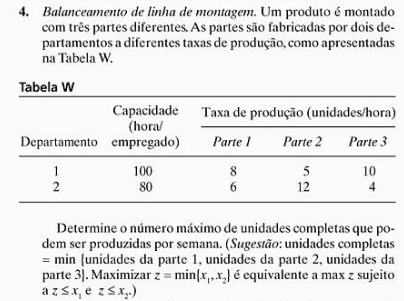

In [1]:
%pip install cplex
%pip install docplex

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from docplex.mp.model import Model

# Criação do modelo com um nome descritivo
model = Model('Balanceamento_Linha_Montagem')

In [3]:
# --- Parâmetros extraídos do enunciado e da Tabela W ---

# Identificadores
departamentos = [1, 2]
partes = [1, 2, 3]

# Capacidade semanal de cada departamento (horas)
capacidade_horas = {1: 100, 2: 80}

# Taxa de produção (unidades/hora)
# Estrutura: taxa_producao[departamento][parte]
taxa_producao = {
    1: {1: 8, 2: 5, 3: 10},
    2: {1: 6, 2: 12, 3: 4}
}

# Conversão da taxa para tempo por unidade (horas/unidade) para as restrições
tempo_por_unidade = {
    d: {p: 1 / taxa_producao[d][p] for p in partes} for d in departamentos
}

In [4]:
# 1. Variáveis de Decisão
# x[d,p] = número de unidades da parte 'p' produzidas no departamento 'd'
producao = model.continuous_var_matrix(departamentos, partes, name='X', lb=0)

# z = número total de unidades completas montadas (nossa variável objetivo)
unidades_completas = model.continuous_var(name='Z', lb=0)


# 2. Função Objetivo
# Maximizar o número de unidades completas
model.maximize(unidades_completas)


# 3. Restrições

# Restrição 1: Capacidade de Horas de Cada Departamento
# O tempo total usado em um departamento não pode exceder sua capacidade semanal.
for d in departamentos:
    expressao_tempo_usado = (tempo_por_unidade[d][p] * producao[d,p] for p in partes)
    soma_tempo_usado = model.sum(expressao_tempo_usado)
    restr_capacidade_logica = soma_tempo_usado <= capacidade_horas[d]
    model.add_constraint(restr_capacidade_logica, ctname=f'capacidade_depto_{d}')

# Restrição 2: Lógica de Montagem
# O número de unidades completas (z) deve ser menor ou igual ao número total de cada parte produzida.
for p in partes:
    soma_total_da_parte = model.sum(producao[d,p] for d in departamentos)
    restr_link_logica = unidades_completas <= soma_total_da_parte
    model.add_constraint(restr_link_logica, ctname=f'gargalo_parte_{p}')

In [5]:
# Aciona o solver para encontrar a solução
print("--- Resolvendo o modelo ---")
solucao = model.solve(log_output=True)

print('\n------ SOLUÇÃO ÓTIMA ------\n')
if solucao:
    unidades_maximas = model.objective_value
    print(f"Número Máximo de Unidades Completas: {unidades_maximas:,.2f} por semana.\n")

    print("--- Plano de Produção (unidades de cada parte) ---")
    for p in partes:
        producao_total_parte = sum(producao[d,p].solution_value for d in departamentos)
        print(f"Parte {p}:")
        print(f"  - Total Produzido: {producao_total_parte:,.2f} unidades")
        for d in departamentos:
            prod_depto = producao[d,p].solution_value
            if prod_depto > 1e-6:
                print(f"    - Depto. {d}: {prod_depto:,.2f} unidades")
else:
    print("Não foi possível encontrar uma solução.")

--- Resolvendo o modelo ---
Version identifier: 22.1.2.0 | 2024-12-10 | f4cec290b
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
No LP presolve or aggregator reductions.
Presolve time = 0.00 sec. (0.00 ticks)

Iteration log . . .
Iteration:     1   Scaled dual infeas =             1.000000

------ SOLUÇÃO ÓTIMA ------

Número Máximo de Unidades Completas: 556.52 por semana.

--- Plano de Produção (unidades de cada parte) ---
Parte 1:
  - Total Produzido: 556.52 unidades
    - Depto. 1: 354.78 unidades
    - Depto. 2: 201.74 unidades
Parte 2:
  - Total Produzido: 556.52 unidades
    - Depto. 2: 556.52 unidades
Parte 3:
  - Total Produzido: 556.52 unidades
    - Depto. 1: 556.52 unidades
